In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.19-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.19-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.19-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

**해당 영역에 IS_COLAB변수를 False로 지정하고, 저장하는 로컬 PC의 데이터파일의 디렉터리로 변경하여주세요.**

In [3]:
# 코랩환경에서 작업여부를 나타내는 변수
IS_COLAB = True 

if IS_COLAB:
  path = "drive/colab/dacon_jeju_traffic/data/"
else:
  path = "I don't know yet"

print(f"path of data files is {path}")

path of data files is drive/colab/dacon_jeju_traffic/data/


In [4]:
# 주요 패키지 import

import os 
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
import plotly.express as px
import plotly.graph_objects as go

# 경고메시지 제거
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
print(f"path of data files is {path}")

path of data files is drive/colab/dacon_jeju_traffic/data/


In [6]:
ls -l drive/colab/dacon_jeju_traffic/data

total 381806
-r--r--r-- 1 root root 289504974 Nov  7 06:53  bus_bts.csv
-rw-r--r-- 1 root root      3063 Apr  2 14:07  Colinearity_90_VIF.csv
-rw-r--r-- 1 root root   2310165 May 11  2019  jeju_financial_life_data.csv
-rw-r--r-- 1 root root      4911 Apr  2 14:07  OLS_coef_corr_90.csv
-rw-r--r-- 1 root root      9008 Mar 30 15:10  PermutationImportance_REF.csv
-rw-r--r-- 1 root root      9118 Apr  2 13:56  SHAP_REF.csv
-rw-r--r-- 1 root root   5982011 Mar 21 06:03 'submission_데이콘 서포터즈 1기_권영인_1주차.csv'
-rw-r--r-- 1 root root   4103729 Mar  8 12:17 'submission_데이콘 서포터즈 1기_권영인.csv'
-r--r--r-- 1 root root   2281715 Nov  7 06:39  submission_sample.csv
-r--r--r-- 1 root root  29758470 Nov  7 06:40  test.csv
-r--r--r-- 1 root root  55756093 Nov  7 06:40  train.csv
-rw-r--r-- 1 root root      3869 Apr  2 14:10  VIF_10_coef_corr.csv
-rw-r--r-- 1 root root      2702 Apr  2 14:10  VIF_10_Selected_VIF.csv
-rw-r--r-- 1 root root      1372 Mar 22 08:33  weather.csv
-r--r--r-- 1 root root   1234237 De

In [0]:
df_train = pd.read_csv(path+"train.csv")
df_test = pd.read_csv(path+"test.csv")
df_bus_bts =  pd.read_csv(path+"bus_bts.csv")
df_jeju_finance = pd.read_csv(path+"jeju_financial_life_data.csv")
df_bjd_location = pd.read_excel(path+"행정_법정동 중심좌표.xlsx")

# EDA와 시각화
  * EDA란?
  * EDA에서 다루는 것들

      1.  데이터의 이해

        - 자료형의 이해 [범주형 / 수치형 데이터]
        - null 값과 이상치

      2.  데이터 시각화

        -  matplotlib과 seaborn
        -  plotly를 활용한 반응형 그래프

## EDA란?

<a href="https://en.wikipedia.org/wiki/Exploratory_data_analysis">EDA</a>는 탐색적 데이터 분석(Exploratory Data Analysis)의 약자로써, 통계에서 종종 **시각적 방법으로 주요 특성을 요약하기 위해 데이터 세트를 분석하는 접근 방식**입니다. 

통계 모델은 사용되거나 사용되지 않을 수 있지만, 주로 EDA는 **공식 모델링 또는 가설 테스트 작업(like 귀무가설, 대립가설) 이외의 데이터가 무엇을 알려줄 수 있는지 확인하기위한 것입니다**. 

John Tukey는 통계학자가 데이터를 탐색하도록 장려하고 새로운 데이터 수집 및 실험으로 이어질 수있는 가설을 공식화하기 위해 탐색 데이터 분석을 추진했습니다. 

EDA는 **초기 데이터 분석 (IDA)과 다릅니다.** [1]은 모형 적합 및 가설 검정에 필요한 가정을 확인하고 결 측값을 처리하고 필요에 따라 변수를 변환하는 데 더 좁게 중점을 둡니다. **EDA는 IDA를 포함합니다.** (From Wikipedia)

### **간단히 말하자면, 통계적인 분석 뿐만 아니라, 열린 결론을 가지고 데이터가 가진 특성을 이해하는 절차** 

#### 1. EDA를 위해서는 주어진 데이터를 이해해야 하며, 진행 전에 나타날 수 있는 다양한 **데이터의 형태를 이해**할 필요가 있다.

#### 2. 이해에 대한 결과를 표나 문서로 구구절절히 설명하는 것보다 하나의 차트로 표현하는 것이 강력하기 때문에, **데이터를 시각화한다.**

## EDA에서 다루는 것들

### 1. 데이터의 이해


#### **자료형의 이해**

<img src="https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F251DC93A5856B11E0C" width=600/>

우리가 자료로 지칭하는 데이터는 크게 **수치형(양적자료) 자료**와 **범주형(질적자료)** 자료로 나눌 수 있습니다.

두 개의 자료를 나누는 기준은 간단히 말해 **특정 값이 집단을 대표할 수 있느냐**를 뜻한다고 생각합니다.

**수치형 자료**는 예를 들면 중학교 중간고사 시험의 개별 학생의 평균점수나 중간고사 시험의 등수와 같은 수치적인 값이 의미를 가지는 데이터입니다. 

**범주형 자료**는 예를들면 반의 학생들의 혈액형이나 반 내 국어시험의 등급을 의미하는 주어진 집단을 특정 값에 의해 군집으로 나눌 수 있는 자료를 의미합니다.

물론 수치형 자료 예를들어 평균점수가 80.5인 사람을 기준으로 집단을 만들어 대표성을 띌 수 있지만, 일반적으로 봤을때 80~90점인사람 처럼 구간을 나눠서 생각을 하게 됩니다. 

따라서 수치형 자료는 **그 수치가 의미가 있는 자료**를 의미하고 그 속에서 이산형 자료는 횟수 등과 같이 정수값으로 **셀 수있는 자료**이며, 그외 **실수로 표현되는 자료**들을 연속형 자료라고 합니다.

그리고 범주형 자료 내에서 나누는 **범주의 값이 순서성을 가지는지**에 따라 순위형 자료와 명목형자료로 나뉩니다. 예를들어 A,B,O 그리고 AB 혈액형은 B가 A보다 먼저 있다고 말할 수 없기 때문에 명목형 자료이고, 국어 성적의 등급과 같이 범주로 나뉘는 명목형 자료이면서 1등급은 9등급보다 더 좋다는 순위를 가지기 때문에 이는 순위형 자료에 속합니다.


In [8]:
df_train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


* 연속형 자료: 위도, 경도
* 이산형 자료: 시간대별 승하차 인원 수

* 순위형 자료: ??
* 명목형 자료: 시내 / 시외 구분

#### **null 값과 이상치**

##### 1. null 값

null은 아래 세가지 내포합니다.

  1. 정의되지 못한 값

  2. 알려지지 않은 값

  3. 존재하지 않는 값


 기본적으로 데이터에 null 값이 있었을 때는 추후 예측시 사용되는 머신러닝 모델이 예측을 수행하지 못했습니다. 그래서 null을 학습데이터에서 제거해주기 위해서는 많은 방법들이 사용되었습니다. 

 예를 들면, 명목형 자료의 경우에는 빈도수가 높은 값을 처리한다던지 또는 수치형 자료의 경우에는 해당 컬럼의 중앙값 또는 평균을 처리하기도 하며, 해당 null 값을 채워주기 위해 학습을 시켜서 예측값을 투입하는 방법도 있습니다.

 ### **Null 값에 대해 처리할 수 있는 인사이트를 발견하자**

훈련 데이터셋

In [9]:
print(f"Null 값을 가지고 있는 컬럼 {list(df_train.columns[df_train.isnull().sum()!=0])} in df_train")

Null 값을 가지고 있는 컬럼 [] in df_train


버스카드 승하차 데이터셋

In [10]:
print(f"Null 값을 가지고 있는 컬럼 {list(df_bus_bts.columns[df_bus_bts.isnull().sum()!=0])} in df_bus_bts")

Null 값을 가지고 있는 컬럼 ['geton_station_name', 'getoff_date', 'getoff_time', 'getoff_station_code', 'getoff_station_name'] in df_bus_bts


##### 2. 이상치(Outlier)

 통계에서 <a href="https://en.wikipedia.org/wiki/Outlier">이상치</a>는 다른 관측치와 크게 다른 데이터입니다. [1] [2] 이상치는 측정의 변동성으로 인한 것일 수도 있고 실험 오류를 나타낼 수도 있습니다. 추후에 때때로 데이터 셋에서 제외된다. [3] 왜냐하면 이상치는 통계 분석에 심각한 문제를 일으킬 수 있습니다. (from wikipedia)

 이상치가 통계적인 분석에 심각한 문제를 일으키는 경우는 '평균의 역설'이라고 생각한다. 예를 들면, 반 평균 점수처럼 반에 엘리트 학생이 많더라도 상대적으로 낮은 점수를 기록하는 학생이 많다면 평균 점수는 일반적으로 변해서 공부 잘하는 학생이 많다는 것 놓칠수 있기 때문이다.

 ## 이상치를 처리하는 방법은 여러가지이다. 
 
 ### 1. 이상치를 무의미하다고 생각하여 신뢰도 등을 활용하여 유의수준 아래의 **데이터를 삭제**할 수도 있지만, 
 ### 2. 이상치를 활용하여 **새로운 데이터를 만들어 낼 수 있다.**

In [11]:
day_type_dict = {0:"weekday",1:"weekday",2:"weekday",3:"weekday",4:"weekday",5:"weekend",6:"weekend"}
day_name_dict = {0:"Mon",1:"Tue",2:"Wed",3:"Thr",4:"Fri",5:"Sat",6:"Sun"}


df_train_date = df_train.date.value_counts().to_frame().sort_index().reset_index()
df_train_date.columns = ["date","count"]
df_train_date["month"] = "Sep"
df_train_date["day"] = df_train_date.date.apply(lambda x: x.split("-")[2])


df_test_date = df_test.date.value_counts().to_frame().sort_index().reset_index()
df_test_date.columns = ["date","count"]
df_test_date["month"] = "Oct"
df_test_date["day"] = df_test_date.date.apply(lambda x: x.split("-")[2])

df_train_test_date = pd.concat([df_train_date,df_test_date],axis=0)
df_train_test_date["day_name"] = df_train_test_date.date.apply(lambda x: day_name_dict[datetime.datetime.strptime(x,"%Y-%m-%d").weekday()])
df_train_test_date["day_type"] = df_train_test_date.date.apply(lambda x: day_type_dict[datetime.datetime.strptime(x,"%Y-%m-%d").weekday()])

df_train_test_date_agg = df_train_test_date.groupby(["month","day_type"])["count"].agg(["max","min","mean"]).sort_index(ascending=False)
df_train_test_date_agg = df_train_test_date_agg.reset_index()
df_train_test_date_agg

,month,day_type,max,min,mean
0,Sep,weekend,13219,6053,10899.222222
1,Sep,weekday,16030,8708,15110.952381
2,Oct,weekend,13395,11836,12625.250000
3,Oct,weekday,16066,11695,14805.750000


훈련셋과 테스트셋 별로 주중과 주말로 나누어 data row 건수를 비교해봤을 때, 일반적으로 주중에는 평균 값이 15000여건 정도 나오지만 가장 낮은 날을 살펴보면 8700여건 정도 밖에 되지 않는다. 그렇게 강하지 않은 이상치일 수 있지만 이를 통해 생각해 볼 수 있다.

In [12]:
sep_mins_list = df_train_test_date[df_train_test_date["month"] == "Sep"].groupby("day_type")["count"].min().values

sep_weekday_min = sep_mins_list[0]
sep_weekend_min = sep_mins_list[1]

df_train_test_date.loc[df_train_test_date["count"] == sep_weekday_min]

,date,count,month,day,day_name,day_type
12,2019-09-13,8708,Sep,13,Fri,weekday


2019년 9월 달력을 한번 살펴보자

<img src="http://blogfiles.naver.net/MjAxOTA4MDRfMjM0/MDAxNTY0ODg0MDUzMDI2.x2ieAErU3yyUSjNpyv5WHArBRXxnbrRkHCsRuL8Yg-Ig.KVrM3LtkP0tpGp9WOeRDn3XS5fJhWqgcpJzqWE2BJAQg.JPEG.modernrocker/2019%B3%E2_9%BF%F9%B4%DE%B7%C2_C.jpg" width=600 height=400 />

2019년 9월 13일은 추석당일로써 공휴일인데 내 생각대로 가장 낮은 날을 기록했다. 그렇다면, 우리의 데이터에 **평일인 공휴일도 나타낼 수 있도록** 해야겠다.

2019년 10월의 달력은 아래와 같다.


<img src="http://blogfiles.naver.net/MjAxOTA5MDhfMjQw/MDAxNTY3OTI3ODE4OTEw.zby6mUfZ5b8sn_jgSLJpy7GPo-8kBIztAKZuJBhbC5gg.CpehvbP3EuhcytW3CM3bjvOBH-H5sHsmB5Feo68-ZHEg.JPEG.modernrocker/2019%B3%E2_10%BF%F9%B4%DE%B7%C2_C.jpg" width=600 height=400 />

따라서 개천절과 한글날인 3일과 9일 모두 포함될 수 있도록 하자.


### 2. 데이터 시각화

시각화의 중요성 때문에 위에서는 데이터프레임 외 다른 방식으로 데이터를 표현하지 않았습니다. 데이터를 시각화 하기 위한 라이브러리는 

1. matplotlib
2. seaborn
3. plotly

등이 있으며, 하나의 대상에 대해 각각의 라이브러리를 활용하여 시각화 해보려고 합니다.

In [0]:
df_train_date_count = df_train.groupby("date")["id"].count().to_frame().reset_index()
df_train_date_count["date"] = df_train.groupby("date")["id"].count().to_frame().reset_index().date.apply(lambda x: x.split("-")[2])
df_train_date_count.columns = ["date","count"]
df_train_date_count["month"] = "Sep"


df_test_date_count = df_test.groupby("date")["id"].count().to_frame().reset_index()
df_test_date_count["date"] = df_test.groupby("date")["id"].count().to_frame().reset_index().date.apply(lambda x: x.split("-")[2])
df_test_date_count.columns = ["date","count"]
df_test_date_count["month"] = "Oct"
df_test_date_count

dummy = pd.concat([df_train_date_count,df_test_date_count],axis=0)
df_date_month_count = dummy.groupby(["date","month"])["count"].max().reset_index()

Text(0.5, 1, 'daily passenger count by month[matplotlib]')

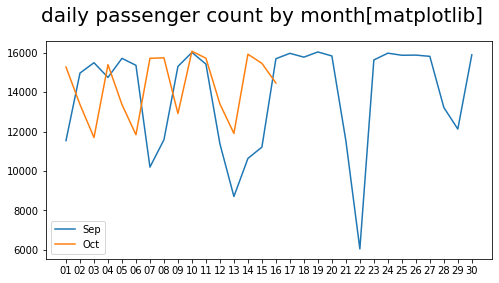

In [14]:
plt.figure(figsize=[8,4])

plt.plot(df_date_month_count.loc[df_date_month_count["month"]=="Sep"]["date"],df_date_month_count.loc[df_date_month_count["month"]=="Sep"]["count"],label="Sep")
plt.plot(df_date_month_count.loc[df_date_month_count["month"]=="Oct"]["date"],df_date_month_count.loc[df_date_month_count["month"]=="Oct"]["count"],label="Oct")
plt.legend()

plt.suptitle("daily passenger count by month[matplotlib]",y=1,fontsize=20)

Text(0.5, 1, 'daily passenger count by month[seaborn]')

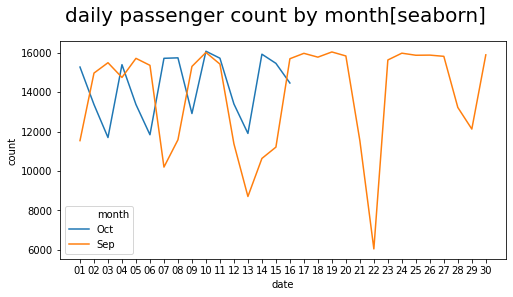

In [15]:
plt.figure(figsize=[8,4])

sns.lineplot(data=df_date_month_count,x="date",y="count",hue="month")

plt.suptitle("daily passenger count by month[seaborn]",y=1,fontsize=20)

In [16]:
fig = go.Figure()

trace_sep = go.Scatter(x=df_date_month_count.loc[df_date_month_count.month=="Sep"].date,y=df_date_month_count.loc[df_date_month_count.month=="Sep"]["count"],name="Sep")
trace_oct = go.Scatter(x=df_date_month_count.loc[df_date_month_count.month=="Oct"].date,y=df_date_month_count.loc[df_date_month_count.month=="Oct"]["count"],name="Oct")

fig.add_trace(trace_sep)
fig.add_trace(trace_oct)

fig.update_layout(title={"text":"daily passenger count by month[plotly]",
                                    "xanchor":"center",
                                    "yanchor":"top",
                                    'y':0.9,
                                    'x':0.5,
                                    "font":{"size":30}},
                            xaxis_title="day of month",
                            yaxis_title="count",
                            width=1000,
                            height=600)

fig.show()

### **그렇다면, <a href="https://towardsdatascience.com/plotly-express-the-good-the-bad-and-the-ugly-dc941649687c">항상 반응형 그래프 plotly를 통해서 표현하는 것은 옳을까?**</a>

### **No. (필자의 생각)** 
 왜냐하면 특정 그래프의 경우에는 plotly가 번거로움이 있기 때문에 그래프에 따라서 적절한 패키지를 활용하여 시각화를 진행해야 할 것이다.